# REST-API example impactu

In [103]:
import pandas as pd
import requests
import json
from IPython.display import JSON
from unidecode import unidecode
def flatten(xss):
    return [x for xs in xss for x in xs]

Obtain "Uiversidad de Antioquia" works

In [104]:
import pandas as pd
import requests
#%%time
DJ = []
total = 107122
#total = 965
page_ini = 1
max_page = 250
extra_page = 0
if total%max_page != 0:
    extra_page = 1
page_end = total//max_page + extra_page
for p in range(page_ini,page_end+1):
    url = f'https://api.dev.impactu.colav.co/affiliation/institution/03bp5hc83/research/products?max={max_page}&page={p}'
    #url = f'https://api.impactu.colav.co/search/works?max={max_page}&page={p}&status=diamond&subjects=1_Library+science'
    dj = requests.get(url)
    if dj.status_code == 200:
        print(p,end="\r")            
        jl = dj.json()['data']
        for d in jl:
            kk = d.pop('abstracts')
        i = 0
        for d in jl:
            if len(jl[i]['authors']) > 100000: #10
                kk = jl.pop(i)
            else:
                i += 1        

        
        DJ = DJ +  jl

In [105]:
len(DJ) # → 104258

107122

save the list to a JSON file

In [106]:
f = open('udea.json','w')
json.dump(DJ,f)
f.close()

In [107]:
ls -lh udea.json

-rw-r--r-- 1 restrepo restrepo 1.6G Feb 28 18:24 udea.json


In [ ]:
f = open('udea.json','r')
DJ = json.load(f)
f.close()

## Analysis in pandas

### Authors

In [108]:
df = pd.DataFrame(DJ)

In [109]:
del DJ

In [110]:
df.shape

(107122, 23)

In [115]:
df['authors_fcen']=df.authors.apply(lambda L: [d for d in L if str(d).find("'name': 'Facultad de Ciencias Exactas y Naturales'") > -1])

search authors

In [97]:
df[:1]

,apc,authors,authors_count,bibliographic_info,citations,citations_by_year,citations_count,date_published,doi,external_ids,...,types,updated,year_published,provenance,type,level_0_scienti,level_1_scienti,level_2_scienti,level_0_minciencias,level_1_minciencias
0,{'paid': {}},"[{'affiliations': [{'end_date': -1, 'geo': {'city': 'Toulouse', 'country': 'France', 'country_code': 'FR', 'latitude': 43.595085, 'longitude': 1.416743}, 'id': '03er61e50', 'name': 'Clinique Paste...",4,{},[],"[{'cited_by_count': 1, 'year': 2024}, {'cited_by_count': 1, 'year': 2023}, {'cited_by_count': 1, 'year': 2022}, {'cited_by_count': 2, 'year': 2021}, {'cited_by_count': 1, 'year': 2020}, {'cited_by...","[{'count': 10, 'source': 'openalex'}]",1.625548e+09,https://doi.org/10.0000/0000,"[{'id': 'https://openalex.org/W4287469585', 'provenance': 'openalex', 'source': 'openalex'}, {'id': 'https://doi.org/10.0000/0000', 'provenance': 'openalex', 'source': 'doi'}, {'id': '0000215856-1...",...,"[{'provenance': 'openalex', 'source': 'openalex', 'type': 'preprint'}, {'provenance': 'openalex', 'source': 'crossref', 'type': 'journal-article'}, {'code': '111', 'level': 2, 'provenance': 'scien...","[{'source': 'openalex', 'time': 1740297049}, {'source': 'scienti', 'time': 1740344705}, {'source': 'scienti', 'time': 1740354001}, {'source': 'minciencias', 'time': 1740365754}]",2021.0,"{scienti, minciencias, openalex}","{Artículo, Nuevo conocimiento, Publicado en revista especializada, Producción bibliográfica, journal-article, Artículos de investigación, preprint}",{Producción bibliográfica},{Artículo},{Publicado en revista especializada},{Nuevo conocimiento},{Artículos de investigación}


In [8]:
full_name = 'diego alejandro restrepo quintero'
#full_name = 'carlos alberto duque echeverri'
dfa = df[df.authors.apply(lambda L: any([True for d in L if unidecode(str(d.get('full_name')).lower()) == full_name ]))]

Check the json:

In [9]:
#JSON(dfa.authors.iloc[0])

De conformidad  con lo dispuesto en el Acuerdo Superior 083 del 22 de julio de 1996 (Estatuto profesoral) la carrera docente de la institución se compone  de las categorías de profesor auxiliar, profesor asistente, profesor asociado y profesor titular. 

In [10]:
#JSON(df.authors.iloc[80049])

remove not scienti authors...

In [11]:
df['scienti_authors'] = df.authors.apply(lambda L: [
                          {'COD_RH':d.get('external_ids')[0].get('id'),
                           'last_names':d.get('last_names'),
                           'first_names':d.get('first_names'),
                           'sex':d.get('sex').lower(),
                           'age':d.get('age'),
                           'affiliations': [{'name': dd.get('name'),
                                             'id': dd.get('id'),
                                             'type': dd.get('types')[0].get('type')
                                            } for dd in d.get('affiliations')],
                           'ranking': [dd for dd in d.get('ranking') if dd.get('source') == 'categoría_laboral' ]
                          } for d in L 
                            if d.get('sex') and 
                            any([True for dd in d.get('external_ids') 
                                 if dd.get('provenance') == 'scienti' and dd.get('source') == 'scienti'])   ])

In [12]:
L = df['scienti_authors'].to_list()
L = flatten(L)
dfL = pd.DataFrame(L)
del L
dfL.shape

(125924, 7)

In [13]:
udea = dfL[dfL['affiliations'].apply(lambda L: [d.get('name') for d in L 
         if d.get('type') == 'Education' and d.get('name') == 'Universidad de Antioquia']).apply(len)>0
         ].reset_index(drop=True)

In [14]:
udea['affiliations'].apply(lambda L: [d.get('name') for d in L 
         if d.get('type') == 'Education']).iloc[0]

['Universidad de Antioquia']

In [15]:
udea.affiliations.iloc[0]

[{'name': 'Universidad de Antioquia', 'id': '03bp5hc83', 'type': 'Education'},
 {'name': 'Instituto de Biología',
  'id': '03bp5hc83_3_21420003_3513',
  'type': 'department'},
 {'name': 'Facultad de Ciencias Exactas y Naturales',
  'id': '03bp5hc83_3',
  'type': 'faculty'},
 {'name': 'Gebiomic (genética y Bioquímica de Microorganismos)',
  'id': 'COL0014064',
  'type': 'group'}]

In [16]:
ror = '03bp5hc83'
udea['faculty'] = udea['affiliations'].apply(lambda L: [d.get('name') for d in L 
         if d.get('type') == 'faculty' and d.get('id').find(ror) > -1  ]).apply(lambda L: L  if len(L) > 0 else 
                                                ['unknown']).str[0]
udea['department'] = udea['affiliations'].apply(lambda L: [d.get('name') for d in L 
         if d.get('type') == 'department' and d.get('id').find(ror) > -1 ]).apply(lambda L: L  if len(L) > 0 else 
                                                ['unknown']).str[0]

udea['group'] = udea['affiliations'].apply(lambda L: [d.get('name') for d in L 
         if d.get('type') == 'group' ]).apply(lambda L: L  if len(L) > 0 else 
                                                ['unknown']).str[0]

In [17]:
udea.shape

(99250, 10)

In [18]:
udea.drop_duplicates(subset=['COD_RH','sex','age','faculty','department','group']).shape

(2673, 10)

In [19]:
udea.drop_duplicates(subset=['COD_RH']).shape

(2673, 10)

In [20]:
udea = udea.drop_duplicates(subset=['COD_RH']).reset_index(drop=True)

In [21]:
fm = udea['sex'].value_counts()
print(f"{round(fm['mujer']/(fm['mujer']+fm['hombre'])*100,1)} % of {fm['mujer']+fm['hombre']}")

44.5 % of 2673


In [22]:
fm = udea['sex'].value_counts()
print(f"UdeA: {round(fm['mujer']/(fm['mujer']+fm['hombre'])*100,1)} % of {fm['mujer']+fm['hombre']}")
for f in udea.faculty.unique() :
    udea_f = udea[udea['faculty'] == f]
    fm = udea_f['sex'].value_counts()
    if not fm.get('mujer'):
        fm['mujer'] = 0
    if not fm.get('hombre'):
        fm['hombre'] = 0        
    print(f"{f}: {round(fm['mujer']/(fm['mujer']+fm['hombre'])*100,1)} % of {fm['mujer']+fm['hombre']}")
    for ff in  udea_f.department.unique():
        udea_d = udea[ ((udea['faculty'] == f) & (udea['department'] == ff)) ]
        fm = udea_d['sex'].value_counts()
        if not fm.get('mujer'):
            fm['mujer'] = 0
        if not fm.get('hombre'):
            fm['hombre'] = 0        
        print(f"   {ff}: {round(fm['mujer']/(fm['mujer']+fm['hombre'])*100,1)} % of {fm['mujer']+fm['hombre']}")

    #if f == 'Escuela de Microbiología':
    #    break

UdeA: 44.5 % of 2673
Facultad de Ciencias Exactas y Naturales: 25.3 % of 293
   Instituto de Biología: 44.0 % of 75
   Instituto de Química: 26.2 % of 80
   Instituto de Física: 11.5 % of 78
   unknown: 33.3 % of 3
   Departamento de Matemáticas: 16.7 % of 54
   Programa Ingeniería Civil: 0.0 % of 1
   Programa Regionalización Urabá: 50.0 % of 2
Facultad de Medicina: 43.9 % of 478
   Departamento de Cirugía: 23.7 % of 59
   Departamento de Pediatría y Puericultura: 53.4 % of 73
   Departamento de Farmacología y Toxicología: 50.0 % of 22
   Departamento de Microbiología y Parasitología: 56.1 % of 57
   Departamento de Medicina Interna: 29.9 % of 77
   Instituto de Investigaciones Médicas: 46.2 % of 39
   Centro de Investigaciones Médicas: 57.1 % of 7
   Departamento de Fisiología: 40.7 % of 27
   Departamento de Siquiatría y Ciencias del Comportamiento Humano: 29.4 % of 17
   Departamento de Morfología: 37.5 % of 8
   Departamento de Bioquímica: 33.3 % of 3
   Departamento de Obstetrici

In [23]:
for r in [ 'AUXILIAR' , 'ASISTENTE','ASOCIADO','TITULAR']:
    fm = udea[udea['ranking'].apply(lambda L: r in [d.get('rank') for d in L])]['sex'].value_counts()
    print(f"{r}: {round(fm['mujer']/(fm['mujer']+fm['hombre'])*100,1)} % of {fm['mujer']+fm['hombre']}")

AUXILIAR: 46.5 % of 1291
ASISTENTE: 46.7 % of 1983
ASOCIADO: 43.2 % of 1187
TITULAR: 41.3 % of 809


In [24]:
f = 'Facultad de Ciencias Exactas y Naturales'
ff = 'Instituto de Física'
udea_f = udea[ ((udea['faculty'] == f)) ]
udea_d = udea[ ((udea['faculty'] == f) & (udea['department'] == ff)) ]

In [25]:
for r in [ 'AUXILIAR' , 'ASISTENTE','ASOCIADO','TITULAR']:
    fm = udea_f[udea_f['ranking'].apply(lambda L: r in [d.get('rank') for d in L])]['sex'].value_counts()
    print(f"{r}: {round(fm['mujer']/(fm['mujer']+fm['hombre'])*100,1)} % of {fm['mujer']+fm['hombre']}")

AUXILIAR: 25.5 % of 110
ASISTENTE: 26.4 % of 208
ASOCIADO: 21.4 % of 126
TITULAR: 20.0 % of 95


In [26]:
for r in [ 'AUXILIAR' , 'ASISTENTE','ASOCIADO','TITULAR']:
    fm = udea_d[udea_d['ranking'].apply(lambda L: r in [d.get('rank') for d in L])]['sex'].value_counts()
    print(f"{r}: {round(fm['mujer']/(fm['mujer']+fm['hombre'])*100,1)} % of {fm['mujer']+fm['hombre']}")

AUXILIAR: 12.0 % of 25
ASISTENTE: 11.1 % of 54
ASOCIADO: 3.1 % of 32
TITULAR: 3.6 % of 28


In [27]:
import matplotlib.pyplot as plt
import numpy as np

In [30]:
udea[udea['age'] < 0]

,COD_RH,last_names,first_names,sex,age,affiliations,ranking,faculty,department,group
83,0000045640,"[Pineda, Salazar]","[David, Antonio]",hombre,-27.0,"[{'name': 'Universidad de Antioquia', 'id': '0...","[{'date': 779432400, 'rank': 'TITULAR', 'sourc...",Facultad de Medicina,Departamento de Medicina Interna,Grupo Neuropsicología y Conducta


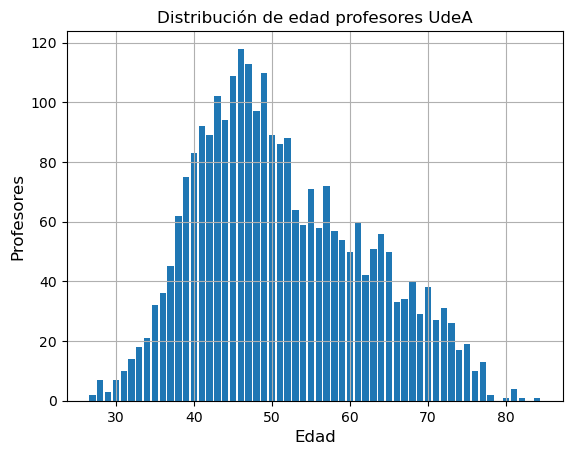

In [41]:
kk = udea[udea['age'] > 0]['age'].sort_values().dropna().astype(int).value_counts()

age = pd.DataFrame()

age['age'] = kk.keys()

age['counts'] = kk.values

age = age.sort_values('age')

plt.bar(age['age'],age['counts'])
plt.xlabel('Edad', size = 12)
plt.ylabel('Profesores', size = 12)
plt.title('Distribución de edad profesores UdeA')
plt.grid()

In [42]:
f = 'Facultad de Ciencias Exactas y Naturales'
ff = 'Instituto de Física'
udea_f = udea[ ((udea['faculty'] == f)) ]
udea_d = udea[ ((udea['faculty'] == f) & (udea['department'] == ff)) ]

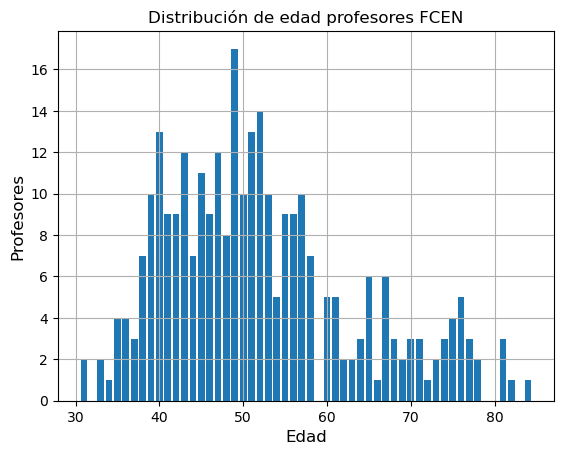

In [43]:
kk = udea_f['age'].sort_values().dropna().astype(int).value_counts()

age = pd.DataFrame()

age['age'] = kk.keys()

age['counts'] = kk.values

age = age.sort_values('age')

plt.bar(age['age'],age['counts'])
plt.xlabel('Edad', size = 12)
plt.ylabel('Profesores', size = 12)
plt.title('Distribución de edad profesores FCEN')
plt.grid()

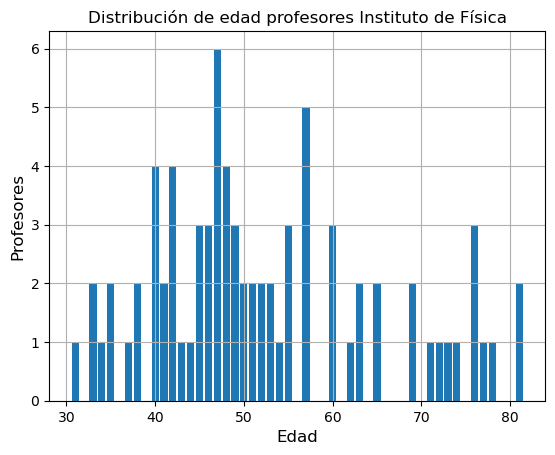

In [44]:
kk = udea_d['age'].sort_values().dropna().astype(int).value_counts()

age = pd.DataFrame()

age['age'] = kk.keys()

age['counts'] = kk.values

age = age.sort_values('age')

plt.bar(age['age'],age['counts'])
plt.xlabel('Edad', size = 12)
plt.ylabel('Profesores', size = 12)
plt.title('Distribución de edad profesores Instituto de Física')
plt.grid()

In [45]:
y = 2020
dfy = df[df.year_published == y]

In [46]:
    L = dfy['scienti_authors'].to_list()
    L = flatten(L)

    dfL = pd.DataFrame(L)

In [47]:
dfL.shape

(7295, 7)

In [48]:
dfL.drop_duplicates('COD_RH').shape

(2453, 7)

In [49]:
df.shape

(104258, 24)

In [50]:
CHECK_OPENALEX = False # Count larger that OpenAlex is expected
if CHECK_OPENALEX:
    df = df[df['types'].apply(lambda L: any([True for d in L 
                                         if d.get('source') == 'openalex' #or
                                             #d.get('type') == 'Artículo'
                                        ]))].reset_index(drop = True)

In [51]:
# df = df[df['types'].apply(lambda L: 'openalex' not in [d.get('source') for d in L])]
# df = df[df['types'].apply(lambda L: 'Artículo' not in [d.get('type') for d in L])].reset_index(drop=True)

In [52]:
df.shape

(104258, 24)

In [53]:
df['openalex'] = df['external_ids'].apply(lambda L: [d.get('id') for d in L if d.get('source') == 'openalex']).str[0]

In [54]:
df.drop_duplicates(subset=['openalex']).shape

(47912, 25)

In [55]:
FACULTY = False
DEPARTMENT = False
UDEA = pd.DataFrame()
w = []
for y in [y for y in set(df.year_published.fillna(0).astype(int)) if y > 0]:
    dfy = df[df.year_published == y]
    if dfy.empty:
        continue
    L = dfy['scienti_authors'].to_list()
    L = flatten(L)
    if not L:
        continue
    dfL = pd.DataFrame(L)
    del L

    # Filter pure UdeA authors
    udeay = dfL[dfL['affiliations'].apply(lambda L: [d.get('name') for d in L 
         if d.get('type') == 'Education' and d.get('name') == 'Universidad de Antioquia']).apply(len)>0
         ].reset_index(drop=True)   

    udeay['faculty'] = udeay['affiliations'].apply(lambda L: [d.get('name') for d in L 
         if d.get('type') == 'faculty' and d.get('id').find(ror) > -1  ]).apply(lambda L: L  if len(L) > 0 else 
                                                ['unknown']).str[0]
    udeay['department'] = udeay['affiliations'].apply(lambda L: [d.get('name') for d in L 
         if d.get('type') == 'department' and d.get('id').find(ror) > -1 ]).apply(lambda L: L  if len(L) > 0 else 
                                                ['unknown']).str[0]
    udeay['group'] = udeay['affiliations'].apply(lambda L: [d.get('name') for d in L 
         if d.get('type') == 'group' ]).apply(lambda L: L  if len(L) > 0 else 
                                                ['unknown']).str[0]    
    udeay = udeay.drop_duplicates(subset=['COD_RH']).reset_index(drop=True)

    udeay['year'] = y
    UDEA = pd.concat((UDEA,udeay)) 
    
    if FACULTY:
        f = 'Facultad de Ciencias Exactas y Naturales'
        udeay = udeay[ ((udeay['faculty'] == f)) ]
    if DEPARTMENT:       
        ff = 'Instituto de Física'
        udeay = udeay[ ((udeay['faculty'] == f) & (udeay['department'] == ff)) ]
    
    #.drop_duplicates(subset=['COD_RH']).reset_index(drop=True)

    d = {}
    d['year'] = y
    d['works'] = dfy.shape[0]
    d['hombre'] = udeay[udeay['sex'] == 'hombre'].shape[0]
    d['mujer'] = udeay[udeay['sex'] == 'mujer'].shape[0]
    d['authors'] = d['hombre'] + d['mujer']
    w.append(d)

Text(0, 0.5, 'works')

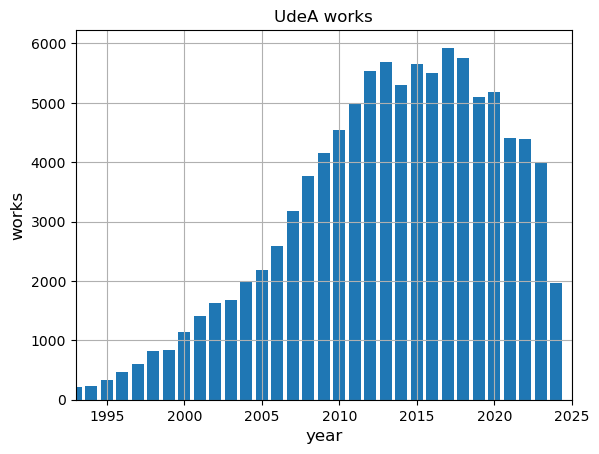

In [56]:
dw = pd.DataFrame(w).sort_values('year')
dw['f/m'] = round(dw['mujer']/dw['authors'],4)

plt.bar(dw['year'],dw['works'])
plt.xlim(1993,2025)
plt.grid()
plt.title('UdeA works')
plt.xlabel('year',size = 12)
plt.ylabel('works',size = 12)

Text(0, 0.5, 'professors')

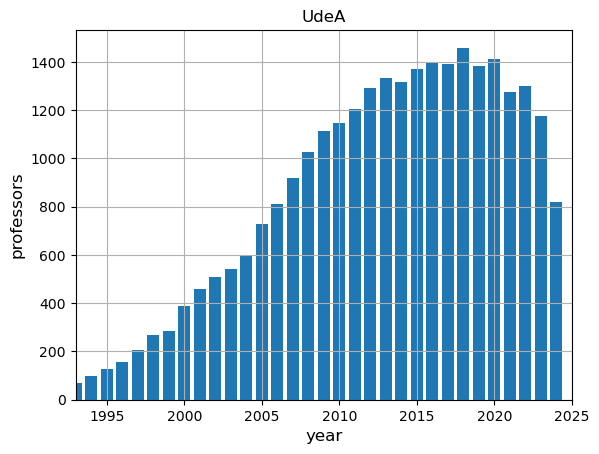

In [57]:
plt.bar(dw['year'],dw['authors'])
plt.xlim(1993,2025)
plt.grid()
plt.title('UdeA')
if FACULTY:
    plt.title(f)
if DEPARTMENT:
    plt.title(ff)

plt.xlabel('year',size = 12)
plt.ylabel('professors',size = 12)

Text(0, 0.5, 'female ratio')

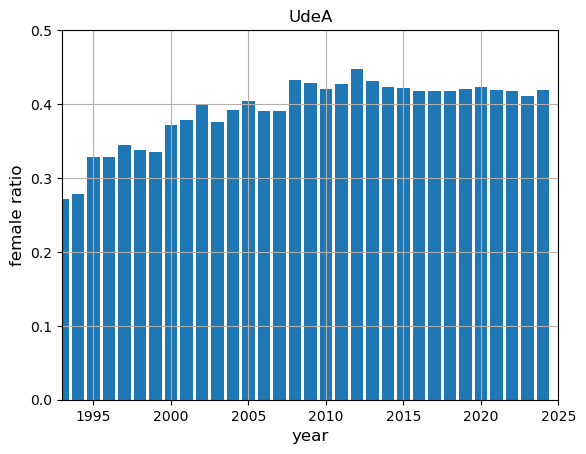

In [58]:
plt.bar(dw['year'],dw['f/m'])
plt.xlim(1993,2025)
plt.grid()
plt.ylim(0,0.5)
if DEPARTMENT:
    plt.xlim(2002,2025)
    plt.ylim(0,0.1)

plt.title('UdeA')
if FACULTY:
    plt.title(f)
if DEPARTMENT:
    plt.title(ff)

plt.xlabel('year',size = 12)
plt.ylabel('female ratio',size = 12)

In [59]:
UDEA['full_name']=UDEA.first_names.apply(' '.join)+' '+UDEA.last_names.apply(' '.join)

In [60]:
y1 = 2020
y2 = 2023
udea_diff = pd.DataFrame({'COD_RH' : list(set(UDEA[UDEA['year']==y1].COD_RH).difference(UDEA[UDEA['year']==y2].COD_RH))})

In [61]:
udea_diff = udea_diff.merge(UDEA.drop_duplicates('COD_RH')[['COD_RH','full_name','faculty','department']],
                on='COD_RH',how='left')

In [62]:
udea_diff.shape

(497, 4)

In [63]:
dw[-5:-3]

,year,works,hombre,mujer,authors,f/m
60,2020,5177,815,596,1411,0.4224
61,2021,4401,741,533,1274,0.4184


In [64]:
print(f'Authors which publish in {y1} but not in {y2}:')
#print(f'in {f}')
#udea_diff[udea_diff['faculty'] == f].reset_index(drop=True)
print(f'in {ff}')
udea_diff[udea_diff['department'] == ff].reset_index(drop=True)

Authors which publish in 2020 but not in 2023:
in Instituto de Física


,COD_RH,full_name,faculty,department
0,0000104647,Jaime Alberto Osorio Velez,Facultad de Ciencias Exactas y Naturales,Instituto de Física
1,0000320714,German Ricaurte Avella,Facultad de Ciencias Exactas y Naturales,Instituto de Física
2,0001581561,Viktor Tulupenko,Facultad de Ciencias Exactas y Naturales,Instituto de Física
3,0001557239,Eduardo Rojas Pena,Facultad de Ciencias Exactas y Naturales,Instituto de Física
4,0000348090,Alvaro Herrera Carrillo,Facultad de Ciencias Exactas y Naturales,Instituto de Física
5,0000731145,Pablo Andres Cuartas Restrepo,Facultad de Ciencias Exactas y Naturales,Instituto de Física
6,0000196878,Fabiola del Socorro Gomez Gomez,Facultad de Ciencias Exactas y Naturales,Instituto de Física
7,0001605958,Volodymyr Akimov,Facultad de Ciencias Exactas y Naturales,Instituto de Física
8,0000247871,Edgar Alberto Rueda Munoz,Facultad de Ciencias Exactas y Naturales,Instituto de Física
9,0000036897,Jorge Enrique Tobon Gomez,Facultad de Ciencias Exactas y Naturales,Instituto de Física


### Types

In [65]:
df = pd.DataFrame(DJ)

In [66]:
del DJ

In [67]:
tp = pd.DataFrame(flatten(df['types'].to_list())).drop_duplicates().sort_values(['provenance','source'] )
tp[:3]

,provenance,source,type,code,level
188587,ciarp,ciarp,Capitulo de libro de ensayo,NaN,NaN
188591,ciarp,ciarp,Impreso universitario,NaN,NaN
188592,ciarp,ciarp,Articulo en revista Tipo A2,NaN,NaN


In [68]:
tp = tp.reset_index(drop=True)
tp['level'] = tp['level'].fillna(0).astype(int)
tp['code'] = tp['code'].fillna(0).astype(str)

In [69]:
p = 'minciencias'
s = 'minciencias'
t = 'Artículos'

In [70]:
2 in {1,2}

True

In [71]:
df['provenance'] = df['types'].apply(lambda L: set([d.get('provenance') for d in L]))
df['source'] = df['types'].apply(lambda L: set([d.get('source') for d in L]))
df['type'] = df['types'].apply(lambda L: set([d.get('type') for d in L]))

In [72]:
c = []
for p,s,t in tp[['provenance','source','type']].values:
    c.append( df[((df['provenance'].apply(lambda L: p in L) ) & 
        (df['source'].apply(lambda L: s in L)) & 
        (df['type'].apply(lambda L: t in L))
       )].shape[0])

In [73]:
tp['counts'] = c

In [74]:
tp.sort_values('counts', ascending=False)[:50]

,provenance,source,type,code,level,counts
113,scienti,scienti,Producción bibliográfica,1,0,51832
89,openalex,openalex,article,0,0,45187
70,openalex,crossref,journal-article,0,0,44126
112,scienti,scienti,Artículo,11,1,33482
143,scienti,scienti,Artículo,1A1,2,33482
122,scienti,scienti,Trabajos dirigidos/Tutorías,6,0,31688
111,scienti,scienti,Publicado en revista especializada,111,2,30214
104,scholar,scholar,article,0,0,24895
49,minciencias,minciencias,Nuevo conocimiento,0,0,18184
135,scienti,scienti,Trabajos de grado de pregrado,64,1,16151


In [75]:
tp[tp['provenance'] == 'minciencias'].sort_values('counts', ascending=False)

,provenance,source,type,code,level,counts
49,minciencias,minciencias,Nuevo conocimiento,0,0,18184
48,minciencias,minciencias,Artículos de investigación,0,1,13498
55,minciencias,minciencias,Formación de recurso humano,0,0,12142
56,minciencias,minciencias,Tesis de pregrado,0,1,7195
51,minciencias,minciencias,Apropiación social del conocimiento,0,0,5891
50,minciencias,minciencias,Artículos,0,1,5625
54,minciencias,minciencias,Tesis de maestria,0,1,4133
52,minciencias,minciencias,Capítulos de libro,0,1,1782
62,minciencias,minciencias,Informe Final de Investigación,0,1,1096
57,minciencias,minciencias,Apropiación social del conocimiento y divulgac...,0,0,1093


Scienti with different `level = 1`

In [76]:
df['level_0_scienti'] = df['types'].apply(
    lambda L: set([d.get('type') for d in L if d.get('provenance') == 'scienti' and d.get('level') == 0
              ]))
df['level_1_scienti'] = df['types'].apply(
    lambda L: set([d.get('type') for d in L if d.get('provenance') == 'scienti' and d.get('level') == 1
              ]))

df['level_2_scienti'] = df['types'].apply(
    lambda L: set([d.get('type') for d in L if d.get('provenance') == 'scienti' and d.get('level') == 2
              ]))

In [77]:
df['level_0_minciencias'] = df['types'].apply(
    lambda L: set([d.get('type') for d in L if d.get('provenance') == 'minciencias' and d.get('level') == 0
              ]))
df['level_1_minciencias'] = df['types'].apply(
    lambda L: set([d.get('type') for d in L if d.get('provenance') == 'minciencias' and d.get('level') == 1
              ]))

In [81]:
df['level_0_scienti']

0         {Producción bibliográfica}
1                                 {}
2         {Producción bibliográfica}
3                                 {}
4         {Producción bibliográfica}
                     ...            
104253                            {}
104254                            {}
104255                            {}
104256                            {}
104257                            {}
Name: level_0_scienti, Length: 104258, dtype: object

In [78]:
df.columns

Index(['apc', 'authors', 'authors_count', 'bibliographic_info', 'citations',
       'citations_by_year', 'citations_count', 'date_published', 'doi',
       'external_ids', 'external_urls', 'groups', 'id', 'keywords',
       'open_access', 'ranking', 'references', 'source', 'subjects', 'titles',
       'types', 'updated', 'year_published', 'provenance', 'type',
       'level_0_scienti', 'level_1_scienti', 'level_2_scienti',
       'level_0_minciencias', 'level_1_minciencias'],
      dtype='object')

products with different scienti `level:0` → different products

In [82]:
df[ df['level_0_scienti'].apply(len) > 1]#[['level_1_scienti','external_ids']].sample().iloc[0].to_dict()

,apc,authors,authors_count,bibliographic_info,citations,citations_by_year,citations_count,date_published,doi,external_ids,...,types,updated,year_published,provenance,type,level_0_scienti,level_1_scienti,level_2_scienti,level_0_minciencias,level_1_minciencias


products with different scienti `level:1` → same product in each case

In [83]:
df[ df['level_1_scienti'].apply(len) > 1][['level_0_minciencias','level_0_scienti','level_1_scienti','external_ids']].sample().iloc[0].to_dict()

{'level_0_minciencias': {'Nuevo conocimiento'},
 'level_0_scienti': {'Producción bibliográfica'},
 'level_1_scienti': {'Artículo', 'Trabajos en eventos (Capítulos de memoria)'},
 'external_ids': [{'id': '0000145858-130',
   'provenance': 'scienti',
   'source': 'scienti'},
  {'id': '0000145858-130', 'provenance': 'scienti', 'source': 'scienti'},
  {'id': '0000177300-142', 'provenance': 'scienti', 'source': 'scienti'},
  {'id': '0000772917-16', 'provenance': 'scienti', 'source': 'scienti'},
  {'id': '104468-0000145858-1740359878',
   'provenance': 'ciarp',
   'source': 'ciarp'},
  {'id': 'ART-0000145858-130',
   'provenance': 'minciencias',
   'source': 'minciencias'},
  {'id': '0000145858-130', 'provenance': 'minciencias', 'source': 'scienti'}]}

products with different scienti `level:2` → same product in each case

In [84]:
kk = df[ df['level_2_scienti'].apply(len) > 1]#
kk[['level_0_scienti','level_1_scienti','level_2_scienti','external_ids']].sample().iloc[0].to_dict()

{'level_0_scienti': {'Producción bibliográfica'},
 'level_1_scienti': {'Artículo'},
 'level_2_scienti': {'Publicado en revista especializada',
  'Revisión (Survey)'},
 'external_ids': [{'id': 'https://openalex.org/W2376394569',
   'provenance': 'openalex',
   'source': 'openalex'},
  {'id': 'https://doi.org/10.17230/ingciencia.12.23.9',
   'provenance': 'openalex',
   'source': 'doi'},
  {'id': 2376394569, 'provenance': 'openalex', 'source': 'mag'},
  {'id': '0000526762-35', 'provenance': 'scienti', 'source': 'scienti'},
  {'id': 'https://doi.org/10.17230/ingciencia.12.23.9',
   'provenance': 'scienti',
   'source': 'doi'},
  {'id': '0001348609-45', 'provenance': 'scienti', 'source': 'scienti'},
  {'id': '8yyE0fWfvmIJ', 'provenance': 'scholar', 'source': 'scholar'},
  {'id': '0001498201-3', 'provenance': 'scienti', 'source': 'scienti'},
  {'id': '14398-31642512-1740359297',
   'provenance': 'ciarp',
   'source': 'ciarp'},
  {'id': '14540-98666408-1740359297',
   'provenance': 'ciarp',


In [85]:
import re

In [86]:
re.search('^Libro','A Libro')

In [87]:
kkk = kk[kk['level_2_scienti'].apply(
    lambda L: [x for x in L if re.search('^Libro',x)]).apply(len) > 0
                       ]
kkk[kkk['level_2_scienti'].apply(lambda L: [x for x in L if re.search('Capítulo',x)]).apply(len) > 0
    ][['level_0_scienti','level_1_scienti','level_2_scienti','external_ids']].sample().iloc[0].to_dict()

{'level_0_scienti': {'Producción bibliográfica'},
 'level_1_scienti': {'Libro'},
 'level_2_scienti': {'Capítulo de libro',
  'Libro pedagógico y/o de divulgación',
  'Otro capítulo de libro publicado'},
 'external_ids': [{'id': '0000030147-39',
   'provenance': 'scienti',
   'source': 'scienti'},
  {'id': '0000030147-39', 'provenance': 'scienti', 'source': 'scienti'},
  {'id': '0000033413-18924', 'provenance': 'scienti', 'source': 'scienti'},
  {'id': '0000826340-26', 'provenance': 'scienti', 'source': 'scienti'},
  {'id': '23523-76320071-1740359297',
   'provenance': 'ciarp',
   'source': 'ciarp'}]}

In [93]:
pd.set_option('display.max_colwidth',200)

In [94]:
df[df['level_0_minciencias'].apply(len) > 0][['level_0_minciencias','level_1_minciencias','level_0_scienti','level_1_scienti','level_2_scienti'
                                             ]].astype(str).drop_duplicates(['level_1_minciencias','level_1_scienti']).sort_values('level_1_minciencias')[:50]

,level_0_minciencias,level_1_minciencias,level_0_scienti,level_1_scienti,level_2_scienti
0,{'Nuevo conocimiento'},{'Artículos de investigación'},{'Producción bibliográfica'},{'Artículo'},{'Publicado en revista especializada'}
31941,{'Nuevo conocimiento'},{'Artículos de investigación'},{'Producción bibliográfica'},"{'Otro artículo publicado', 'Otra producción bibliográfica', 'Trabajos en eventos (Capítulos de memoria)'}","{'Revista de divulgación', 'Completo', 'Otra'}"
2581,{'Nuevo conocimiento'},{'Artículos de investigación'},{'Trabajos dirigidos/Tutorías'},{'Trabajo de grado de maestría o especialidad clínica'},set()
2917,{'Nuevo conocimiento'},{'Artículos de investigación'},{'Producción bibliográfica'},"{'Artículo', 'Documento de trabajo (Working Paper)'}","{'Publicado en revista especializada', 'Corto (Resumen)'}"
3534,{'Nuevo conocimiento'},{'Artículos de investigación'},{'Producción bibliográfica'},{'Trabajos en eventos (Capítulos de memoria)'},{'Completo'}
70884,{'Nuevo conocimiento'},{'Artículos de investigación'},{'Trabajos dirigidos/Tutorías'},{'Monografía de conclusión de curso de perfeccionamiento/especialización'},set()
30327,{'Nuevo conocimiento'},{'Artículos de investigación'},{'Producción bibliográfica'},{'Documento de trabajo (Working Paper)'},set()
5404,{'Nuevo conocimiento'},{'Artículos de investigación'},{'Producción bibliográfica'},"{'Artículo', 'Otra producción bibliográfica'}","{'Publicado en revista especializada', 'Otra'}"
30303,{'Nuevo conocimiento'},{'Artículos de investigación'},{'Producción bibliográfica'},"{'Libro', 'Trabajos en eventos (Capítulos de memoria)'}","{'Capítulo de libro', 'Completo'}"
7850,{'Nuevo conocimiento'},{'Artículos de investigación'},{'Producción bibliográfica'},"{'Artículo', 'Nota científica'}",{'Publicado en revista especializada'}


In [96]:
df[['titles','types','external_ids']].iloc[35637].to_dict()

{'titles': [{'lang': 'es',
   'source': 'openalex',
   'title': "Alimentos funcionales. 'Alimentos funcionales'"},
  {'lang': 'es',
   'source': 'scienti',
   'title': 'VIDA ÚTIL FISICOQUÍMICA DE ALIMENTOS FUNCIONALES'},
  {'lang': 'es',
   'provenance': 'ciarp',
   'source': 'ciarp',
   'title': 'ALIMENTOS FUNCIONALES: MITOS Y REALIDADES'},
  {'lang': 'es',
   'source': 'minciencias',
   'title': 'VIDA ÚTIL FISICOQUÍMICA DE ALIMENTOS FUNCIONALES'}],
 'types': [{'provenance': 'openalex', 'source': 'openalex', 'type': 'article'},
  {'provenance': 'openalex', 'source': 'crossref', 'type': 'journal-article'},
  {'code': '113',
   'level': 2,
   'provenance': 'scienti',
   'source': 'scienti',
   'type': 'Revisión (Survey)'},
  {'code': '11',
   'level': 1,
   'provenance': 'scienti',
   'source': 'scienti',
   'type': 'Artículo'},
  {'code': '1',
   'level': 0,
   'provenance': 'scienti',
   'source': 'scienti',
   'type': 'Producción bibliográfica'},
  {'code': '141',
   'level': 2,
   '

In [240]:
tpu = df[((df['provenance'].apply(lambda L: p in L) ) & 
        (df['source'].apply(lambda L: s in L)) & 
        (df['type'].apply(lambda L: t in L))
       )][['provenance','source','type']].astype(str).drop_duplicates().reset_index(drop=True)

tpu['provenance'] = tpu['provenance'].apply(eval)

tpu['source'] = tpu['source'].apply(eval)

tpu['type'] = tpu['type'].apply(eval)

In [117]:
pd.set_option('display.max_colwidth',500)

In [119]:
#pd.set_option('display.max_rows', 500)

In [239]:
tpu[:1]

,provenance,source,type
0,"{minciencias, openalex, scholar}","{minciencias, openalex, crossref, scholar}","{Artículos, article, reference-entry, Apropiación social del conocimiento}"


minciencias → scienti

In [276]:
kk = df[df['type'].apply(lambda L:'Desarrollo tecnológico e innovación' in L)]
#kk[kk['provenance'].apply(lambda L: 'scienti' in L)][['type','provenance','types']]#.to_dict(orient = 'records')

In [282]:
kk[kk['provenance'].apply(lambda L: 'scienti' in L)][['level_1_scienti','level_2_scienti']]

,level_1_scienti,level_2_scienti
50688,{Libro},{Libro resultado de investigación}
80826,{Trabajos en eventos (Capítulos de memoria)},{Resumen}
87615,{Trabajos dirigidos/Tutorías de otro tipo},{}


In [301]:
from fuzzywuzzy import fuzz

In [302]:
fuzz.ratio('Initial Atmospheric Corrosion of Copper Induced by Carboxylic Acids"'.lower(),
           "The Initial Atmospheric Corrosion of Copper and Zinc Induced by Carboxylic Acids".lower())

91

## Citations

In [132]:
def hIndex(citations):
    """
    https://github.com/kamyu104/LeetCode/blob/master/Python/h-index.py
    :type citations: List[int]
    :rtype: int
    
    # Given an array of citations (each citation is a non-negative integer)
    # of a researcher, write a function to compute the researcher's h-index.
    #
    # According to the definition of h-index on Wikipedia: 
    # "A scientist has index h if h of his/her N papers have
    # at least h citations each, and the other N − h papers have
    # no more than h citations each."
    #
    # For example, given citations = [3, 0, 6, 1, 5], 
    # which means the researcher has 5 papers in total
    # and each of them had received 3, 0, 6, 1, 5 citations respectively. 
    # Since the researcher has 3 papers with at least 3 citations each and 
    # the remaining two with no more than 3 citations each, his h-index is 3.
    #
    # Note: If there are several possible values for h, the maximum one is taken as the h-index.
    """
    import builtins
    sum=builtins.sum
    return sum(x >= i + 1 for i, x in enumerate(sorted(  list(citations), reverse=True)))

In [120]:
dfcen = df[df['authors_fcen'].apply(len)>0].reset_index(drop = True)

In [124]:
afcen = dfcen['authors_fcen'].apply(lambda L: [d.get('id') for d in L]).apply(pd.Series).stack().unique()

In [126]:
a = afcen[0]

In [127]:
a

'67b8e2058522a9c4bc2966c2'

In [161]:
dafcen = dfcen[dfcen['authors_fcen'].astype(str).str.contains(a)].reset_index(drop =True)
    

In [235]:
i = 0
Lfcen = []
for a in afcen:
    dafcen = dfcen[dfcen['authors_fcen'].astype(str).str.contains(a)].reset_index(drop =True)
    dafcen['author_fcen'] = dafcen['authors_fcen'].apply(lambda L: [d for d in L if d.get('id') == a])

    full_name = dafcen['author_fcen'].str[0].str['full_name'].iloc[0]
    try:
        department = dafcen['author_fcen'].str[0].str['affiliations'].apply(
                        lambda L: [d.get('name') for d in L 
                                   if d.get('types')[0].get('type') == 'department']).iloc[0][0]
    except:
        department = ''

    
    # TODO: get all the articles from the author by using the API on a → fdfcen
        #fdafcen = fdfcen[fdfcen['authors'].astype(str).str.contains(a)].reset_index(drop =True)

    L = dafcen['citations_count'].apply(
        lambda L: [d.get('count') for d in L if d.get('source') == 'openalex']
         ).apply(pd.Series).stack().unique()
    L = [int(x) for x in L]
    
    h_index = hIndex(L)
    citations = sum(L)
    
    Lfcen.append({'full_name': full_name, 'department' : department, 'citations': citations, 'h_index': h_index, 'id': a})
    print(i,end='\r')
    #if i == 3:
    #    break
    i += 1

In [214]:
h_index_df = pd.DataFrame(Lfcen)
h_index_df['impactu'] = h_index_df['id'].apply(lambda s: f'https://dev.impactu.colav.co/person/{s}/research/products')

In [215]:
h_index_df.to_excel('fcen_h_index.xlsx', index=False)

In [224]:
h_index_df['department'] = h_index_df.department.str.replace('Departamento','Instituto')

In [231]:
h_index_df = h_index_df[h_index_df.department.apply(lambda d: d in ['Instituto de Biología', 'Instituto de Química',
       'Instituto de Física',  'Instituto de Matemáticas'])
      ].sort_values(['department','h_index'],ascending=False).reset_index(drop=True)

In [234]:
h_index_df.to_excel('fcen_h_index.xlsx', index=False)